In [ ]:
# Standard library imports
import os
import xml.etree.ElementTree as ET

# TensorFlow and image processing
import tensorflow as tf
from PIL import Image

# Scikit-learn for model evaluation and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Matplotlib and Seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [1]:
# Define paths to your datasets
bccd_annotations_dir = './BCCD_Dataset/BCCD/Annotations'
bccd_images_dir = './BCCD_Dataset/BCCD/Images'
cbc_annotations_dir = './Complete-Blood-Cell-Count-Dataset/Training/Annotations'
cbc_images_dir = './Complete-Blood-Cell-Count-Dataset/Training/Images'

# Function to parse annotation files
def parse_annotations(annotations_dir, images_dir, prefix):
    data = []
    for filename in os.listdir(annotations_dir):
        if filename.endswith('.xml'):
            tree = ET.parse(os.path.join(annotations_dir, filename))
            root = tree.getroot()
            image_filename = filename.replace('.xml', '.jpg')
            image_path = os.path.join(images_dir, image_filename)
            objects = root.findall('object')
            for obj in objects:
                class_name = obj.find('name').text
                bbox = obj.find('bndbox')
                bbox_coords = {
                    'xmin': int(bbox.find('xmin').text),
                    'ymin': int(bbox.find('ymin').text),
                    'xmax': int(bbox.find('xmax').text),
                    'ymax': int(bbox.find('ymax').text)
                }
                data.append({
                    'image_path': image_path,
                    'class': class_name,
                    'bbox': bbox_coords,
                    'prefix': prefix
                })
    return data

# Load BCCD dataset
bccd_data = parse_annotations(bccd_annotations_dir, bccd_images_dir, 'BCCD')

# Load CBC dataset
cbc_data = parse_annotations(cbc_annotations_dir, cbc_images_dir, 'CBC')

# Combine datasets
combined_data = bccd_data + cbc_data

# Print summary of loaded data
print(f'Total BCCD data items: {len(bccd_data)}')
print(f'Total CBC data items: {len(cbc_data)}')
print(f'Total combined data items: {len(combined_data)}')


Total BCCD data items: 4888
Total CBC data items: 3952
Total combined data items: 8840


In [2]:
# Define directories
bccd_image_dir = './BCCD_Dataset/BCCD/JPEGImages'
bccd_annotation_dir = './BCCD_Dataset/BCCD/Annotations'

cbc_image_dirs = [
    './Complete-Blood-Cell-Count-Dataset/Training/Images',
    './Complete-Blood-Cell-Count-Dataset/Validation/Images',
    './Complete-Blood-Cell-Count-Dataset/Testing/Images'
]
cbc_annotation_dirs = [
    './Complete-Blood-Cell-Count-Dataset/Training/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Validation/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Testing/Annotations'
]

pbc_image_dirs = [
    './PBC_dataset_normal_DIB/basophil',
    './PBC_dataset_normal_DIB/eosinophil',
    './PBC_dataset_normal_DIB/erythroblast',
    './PBC_dataset_normal_DIB/ig',
    './PBC_dataset_normal_DIB/lymphocyte',
    './PBC_dataset_normal_DIB/monocyte',
    './PBC_dataset_normal_DIB/neutrophil',
    './PBC_dataset_normal_DIB/platelet'
]

# Verify directories existence
for dir_path in [bccd_image_dir] + cbc_image_dirs + pbc_image_dirs:
    if not os.path.exists(dir_path):
        raise FileNotFoundError(f"Directory not found: {dir_path}")

# Create unified dataset directory
unified_image_dir = './unified_dataset/Images'
os.makedirs(unified_image_dir, exist_ok=True)

def create_symlink_with_prefix(image_dir, prefix):
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            src = os.path.join(image_dir, filename)
            dst = os.path.join(unified_image_dir, f"{prefix}_{filename}")
            try:
                os.symlink(src, dst)
            except FileExistsError:
                print(f"Warning: Skipping duplicate image {dst}")

# Create symbolic links with prefixes to avoid naming conflicts
create_symlink_with_prefix(bccd_image_dir, 'bccd')

for i, dir_path in enumerate(cbc_image_dirs):
    create_symlink_with_prefix(dir_path, f'cbc_{i}')

for i, dir_path in enumerate(pbc_image_dirs):
    create_symlink_with_prefix(dir_path, f'pbc_{i}')

print("Unified dataset created successfully.")

Unified dataset created successfully.


In [3]:
def get_bccd_classes(annotation_dir):
    classes = set()
    for filename in os.listdir(annotation_dir):
        if filename.endswith('.xml'):
            tree = ET.parse(os.path.join(annotation_dir, filename))
            root = tree.getroot()
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                classes.add(class_name)
    return classes

bccd_annotation_dir = './BCCD_Dataset/BCCD/Annotations'
bccd_classes = get_bccd_classes(bccd_annotation_dir)
print(f"BCCD Classes: {bccd_classes}")

cbc_annotation_dirs = [
    './Complete-Blood-Cell-Count-Dataset/Testing/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Training/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Validation/Annotations'
]

cbc_classes = set()
for dir_path in cbc_annotation_dirs:
    cbc_classes.update(get_bccd_classes(dir_path))

print(f"CBC Classes: {cbc_classes}")

pbc_classes = set(os.listdir('./PBC_dataset_normal_DIB'))
print(f"PBC Classes: {pbc_classes}")

# Combine all classes
all_classes = bccd_classes.union(cbc_classes).union(pbc_classes)
print(f"All Classes: {all_classes}")
num_classes = len(all_classes)

# Create a mapping from class names to indices
class_to_index = {cls: idx for idx, cls in enumerate(all_classes)}
print(f"Class to Index Mapping: {class_to_index}")


BCCD Classes: {'WBC', 'RBC', 'Platelets'}
CBC Classes: {'WBC', 'RBC', 'Platelets'}
PBC Classes: {'eosinophil', 'erythroblast', 'lymphocyte', 'basophil', 'neutrophil', '.DS_Store', 'platelet', 'monocyte', 'ig'}
All Classes: {'eosinophil', 'WBC', 'erythroblast', 'Platelets', 'lymphocyte', 'basophil', 'neutrophil', 'RBC', '.DS_Store', 'platelet', 'monocyte', 'ig'}
Class to Index Mapping: {'eosinophil': 0, 'WBC': 1, 'erythroblast': 2, 'Platelets': 3, 'lymphocyte': 4, 'basophil': 5, 'neutrophil': 6, 'RBC': 7, '.DS_Store': 8, 'platelet': 9, 'monocyte': 10, 'ig': 11}


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Directory paths
bccd_dir = './BCCD_Dataset/BCCD/JPEGImages/'
cbcc_dir = './Complete-Blood-Cell-Count-Dataset/Training/Images/'
pbc_dir = './PBC_dataset_normal_DIB/'

# Class names and indices
class_names = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'Lymphocyte', 
               'monocyte', 'neutrophil', 'platelet', 'RBC', 'WBC', 'other']
class_to_index = {name: index for index, name in enumerate(class_names)}

# Function to check if an image file is valid
def is_valid_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is an image
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image file: {image_path} - {e}")
        return False

# Get all file paths and corresponding labels
def get_all_files_and_labels():
    all_files = []
    for class_name in class_names:
        # PBC dataset
        pbc_class_dir = os.path.join(pbc_dir, class_name)
        if os.path.isdir(pbc_class_dir):
            pbc_files = [os.path.join(pbc_class_dir, f) for f in os.listdir(pbc_class_dir) if f.endswith('.jpg')]
            valid_pbc_files = [(f, class_to_index[class_name]) for f in pbc_files if is_valid_image(f)]
            all_files.extend(valid_pbc_files)

        # BCCD dataset
        bccd_files = [os.path.join(bccd_dir, f) for f in os.listdir(bccd_dir) if f.endswith('.jpg')]
        valid_bccd_files = [(f, class_to_index['RBC'] if 'RBC' in f else class_to_index['WBC'] if 'WBC' in f else class_to_index['platelet']) for f in bccd_files if is_valid_image(f)]
        all_files.extend(valid_bccd_files)

        # CBCC dataset
        cbcc_files = [os.path.join(cbcc_dir, f) for f in os.listdir(cbcc_dir) if f.endswith('.jpg')]
        valid_cbcc_files = [(f, class_to_index['RBC'] if 'RBC' in f else class_to_index['WBC'] if 'WBC' in f else class_to_index['platelet']) for f in cbcc_files if is_valid_image(f)]
        all_files.extend(valid_cbcc_files)

    return all_files

all_files_and_labels = get_all_files_and_labels()

# Create a TensorFlow dataset
file_paths, labels = zip(*all_files_and_labels)
list_ds = tf.data.Dataset.from_tensor_slices((list(file_paths), list(labels)))
print("list_ds:")
print(list_ds)


Invalid image file: ./PBC_dataset_normal_DIB/neutrophil/.DS_169665.jpg - cannot identify image file './PBC_dataset_normal_DIB/neutrophil/.DS_169665.jpg'
list_ds:
<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


In [5]:
# Define the parse function for the datasets
def parse_function(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    return image, label

# Apply the parse function and batch the datasets
train_ds = list_ds.map(parse_function, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

# Ensure there are batches to process
assert tf.data.experimental.cardinality(train_ds).numpy() > 0, "The dataset is empty!"
print("Dataset after batching and prefetching:")
for batch in train_ds.take(1):
    print(batch)


Dataset after batching and prefetching:
(<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[252.91797, 228.91797, 200.91797],
         [252.91797, 228.91797, 200.91797],
         [252.91797, 228.91797, 200.91797],
         ...,
         [195.08203, 156.08203, 159.08203],
         [197.02307, 158.02307, 161.02307],
         [199.     , 160.     , 163.     ]],

        [[255.     , 231.     , 203.     ],
         [255.     , 231.     , 203.     ],
         [255.     , 231.     , 203.     ],
         ...,
         [193.46875, 154.46875, 157.46875],
         [196.28125, 157.28125, 160.28125],
         [199.07068, 160.07068, 163.07068]],

        [[252.41016, 228.41016, 200.41016],
         [252.41016, 228.41016, 200.41016],
         [252.41016, 228.41016, 200.41016],
         ...,
         [195.27649, 156.27649, 159.27649],
         [199.15234, 160.15234, 163.15234],
         [203.58984, 164.58984, 167.58984]],

        ...,

        [[253.09375, 230.09375, 196.91406],
  

In [6]:
# Define data augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

In [7]:
# Split the dataset into training and testing sets (80% training, 20% testing)
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# Create TensorFlow datasets for training and testing
train_ds = tf.data.Dataset.from_tensor_slices((list(train_files), list(train_labels)))
test_ds = tf.data.Dataset.from_tensor_slices((list(test_files), list(test_labels)))

# Apply the parse function and batch the datasets
train_ds = train_ds.map(parse_function, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
test_ds = test_ds.map(parse_function, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

# Ensure there are batches to process
assert tf.data.experimental.cardinality(train_ds).numpy() > 0, "The training dataset is empty!"
assert tf.data.experimental.cardinality(test_ds).numpy() > 0, "The testing dataset is empty!"

print("Training dataset:")
for batch in train_ds.take(1):
    print(batch)

print("Testing dataset:")
for batch in test_ds.take(1):
    print(batch)


Training dataset:
(<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[254.08203, 230.08203, 202.08203],
         [254.08203, 230.08203, 202.08203],
         [254.08203, 230.08203, 202.08203],
         ...,
         [203.     , 169.     , 160.     ],
         [205.28125, 171.28125, 162.28125],
         [207.08203, 173.08203, 164.08203]],

        [[253.2461 , 229.2461 , 201.2461 ],
         [253.2461 , 229.2461 , 201.2461 ],
         [253.2461 , 229.2461 , 201.2461 ],
         ...,
         [202.2461 , 167.2461 , 162.7539 ],
         [203.2461 , 168.2461 , 163.7539 ],
         [204.2461 , 169.2461 , 164.7539 ]],

        [[252.41016, 228.41016, 200.41016],
         [252.41016, 228.41016, 200.41016],
         [252.41016, 228.41016, 200.41016],
         ...,
         [202.     , 167.     , 165.     ],
         [201.8341 , 166.8341 , 164.8341 ],
         [201.41016, 166.41016, 164.41016]],

        ...,

        [[212.6836 , 178.6836 , 168.6836 ],
         [210.7052 , 175

In [8]:
# Define the model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

# Train the model
history = model.fit(train_ds, epochs=10)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [9]:
# Print the history dictionary
print(history.history)


{'loss': [1.0619374513626099, 0.22026710212230682, 0.1557592898607254, 0.12836365401744843, 0.11484354734420776, 0.09599589556455612, 0.08918590098619461, 0.08288821578025818, 0.08951322734355927, 0.07019852101802826], 'accuracy': [0.8085673451423645, 0.9234474301338196, 0.9466078877449036, 0.9568046927452087, 0.9594691395759583, 0.9675650596618652, 0.9707419276237488, 0.9719204902648926, 0.969409704208374, 0.9759684205055237]}


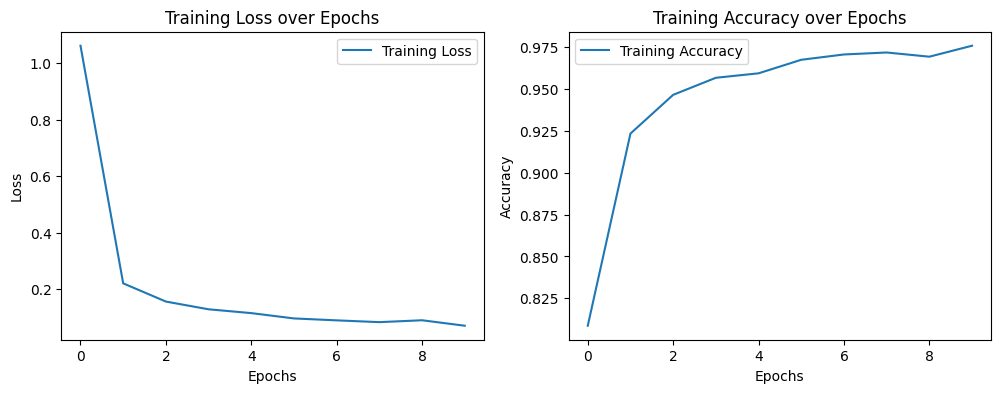

In [10]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history.get('loss', []), label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.show()



153/153 [==============================] - 8s 50ms/step
              precision    recall  f1-score   support

    basophil       0.82      0.93      0.87       238
  eosinophil       1.00      0.98      0.99       663
erythroblast       0.94      0.87      0.90       290
          ig       0.83      0.85      0.84       596
  Lymphocyte       0.95      0.95      0.95       243
    monocyte       0.80      0.88      0.84       280
  neutrophil       0.97      0.93      0.95       665
    platelet       1.00      0.99      1.00      1905

    accuracy                           0.95      4880
   macro avg       0.91      0.92      0.92      4880
weighted avg       0.95      0.95      0.95      4880



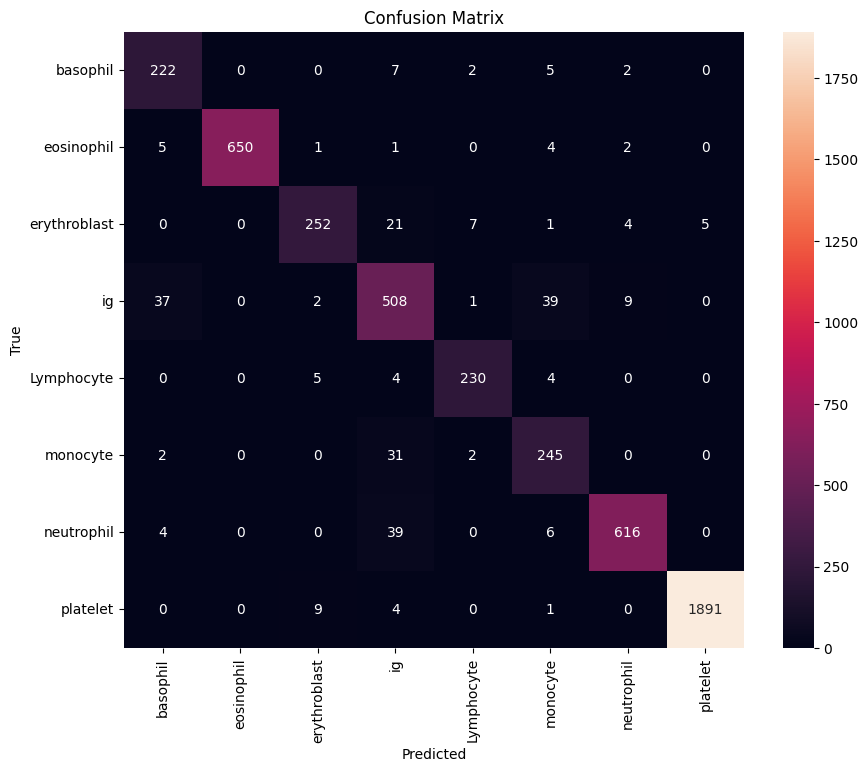

In [12]:
# Get predictions
y_pred = model.predict(test_ds)
y_pred_classes = tf.argmax(y_pred, axis=1)

# Get true labels
y_true = tf.concat([y for x, y in test_ds], axis=0)

# Ensure both y_true and y_pred_classes are in the same format
y_true = y_true.numpy()
y_pred_classes = y_pred_classes.numpy()

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names[:8])  # Assuming only 8 classes are present in test data
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=list(range(8)))  # Labels are indices of the present classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names[:8], yticklabels=class_names[:8])  # Assuming only 8 classes are present
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [13]:
# Save the entire model as a SavedModel.
model.save('model/my_model')


INFO:tensorflow:Assets written to: path_to_save_model/my_model/assets


INFO:tensorflow:Assets written to: path_to_save_model/my_model/assets


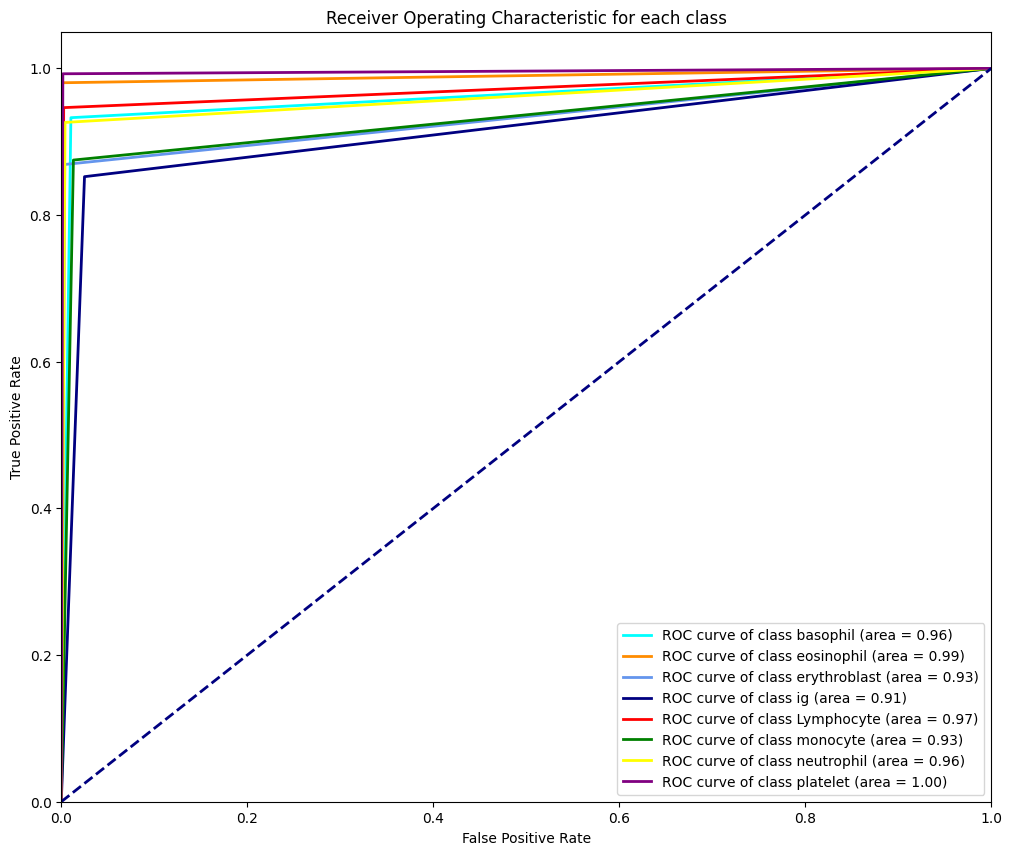

In [16]:
# Assuming y_true and y_pred are your true and predicted labels respectively
n_classes = len(class_names)

# Binarize the output
y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))
y_pred_binarized = label_binarize(y_pred_classes, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    if y_true_binarized[:, i].sum() == 0:
        continue  # Skip classes with no positive samples in y_true
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 10))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'navy', 'red', 'green', 'yellow', 'purple', 'pink', 'brown', 'grey']
for i in range(n_classes):
    if i in fpr:  # Plot only for classes with valid ROC values
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()
